## Import ISTA-Net model weights and utility functions

In [2]:
import numpy as np

def compute_psnr(original, reconstructed):
    """
    Calcule le PSNR entre l'image originale et l'image reconstruite.

    :param original: Image originale (numpy array, valeurs entre 0 et 1)
    :param reconstructed: Image reconstruite (numpy array, valeurs entre 0 et 1)
    :return: Valeur du PSNR en dB
    """
    mse = np.mean((original - reconstructed) ** 2)  # Erreur quadratique moyenne
    if mse == 0:
        return float('inf')  # PSNR infini si pas d'erreur
    max_pixel = 255.0  # L'image est normalisée entre 0 et 1
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))  # Formule PSNR
    return psnr


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io as sio
import numpy as np
import os
import glob
from time import time
import math
from torch.nn import init
import copy
import cv2
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Configuration des paramètres
config = {
    "epoch_num": 200,
    "layer_num": 9,
    "learning_rate": 1e-4,
    "group_num": 1,
    "cs_ratio": 40,
    "gpu_list": "0",
    "matrix_dir": "sampling_matrix",
    "model_dir": "model",
    "data_dir": "data",
    "log_dir": "log",
    "result_dir": "result",
    "test_name": "Set11"
}

# Configuration GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = config["gpu_list"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ratio_dict = {1: 10, 4: 43, 10: 109, 25: 272, 30: 327, 40: 436, 50: 545}
n_input = ratio_dict[config["cs_ratio"]]
n_output = 1089

# Chargement de la matrice de sampling
Phi_data_Name = f'./{config["matrix_dir"]}/phi_0_{config["cs_ratio"]}_1089.mat'
Phi_data = sio.loadmat(Phi_data_Name)
Phi_input = Phi_data['phi']

# Définition du modèle ISTA-Net
class BasicBlock(torch.nn.Module):
    def __init__(self):
        super(BasicBlock, self).__init__()
        self.lambda_step = nn.Parameter(torch.Tensor([0.5]))
        self.soft_thr = nn.Parameter(torch.Tensor([0.01]))
        self.conv1_forward = nn.Parameter(init.xavier_normal_(torch.Tensor(32, 1, 3, 3)))
        self.conv2_forward = nn.Parameter(init.xavier_normal_(torch.Tensor(32, 32, 3, 3)))
        self.conv1_backward = nn.Parameter(init.xavier_normal_(torch.Tensor(32, 32, 3, 3)))
        self.conv2_backward = nn.Parameter(init.xavier_normal_(torch.Tensor(1, 32, 3, 3)))
    
    def forward(self, x, PhiTPhi, PhiTb):
        x = x - self.lambda_step * torch.mm(x, PhiTPhi)
        x = x + self.lambda_step * PhiTb
        x_input = x.view(-1, 1, 33, 33)
        x = F.relu(F.conv2d(x_input, self.conv1_forward, padding=1))
        x_forward = F.conv2d(x, self.conv2_forward, padding=1)
        x = torch.mul(torch.sign(x_forward), F.relu(torch.abs(x_forward) - self.soft_thr))
        x = F.relu(F.conv2d(x, self.conv1_backward, padding=1))
        x_backward = F.conv2d(x, self.conv2_backward, padding=1)
        x_pred = x_backward.view(-1, 1089)
        return x_pred

class ISTANet(torch.nn.Module):
    def __init__(self, LayerNo):
        super(ISTANet, self).__init__()
        self.LayerNo = LayerNo
        self.fcs = nn.ModuleList([BasicBlock() for _ in range(LayerNo)])
    
    def forward(self, Phix, Phi, Qinit):
        PhiTPhi = torch.mm(Phi.T, Phi)
        PhiTb = torch.mm(Phix, Phi)
        x = torch.mm(Phix, Qinit.T)
        for layer in self.fcs:
            x = layer(x, PhiTPhi, PhiTb)
        return x

# Chargement du modèle
model = ISTANet(config["layer_num"])
model = nn.DataParallel(model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

model_dir = f"./{config['model_dir']}/CS_ISTA_Net_layer_{config['layer_num']}_group_{config['group_num']}_ratio_{config['cs_ratio']}_lr_{config['learning_rate']:.4f}"
model.load_state_dict(torch.load(f'{model_dir}/net_params_{config["epoch_num"]}.pkl', map_location=device))


<All keys matched successfully>

In [17]:
lambda_fista = model.state_dict()['module.fcs.7.lambda_step'].item()
soft_thr_fista = model.state_dict()['module.fcs.7.soft_thr'].item()

conv1_f = model.state_dict()['module.fcs.7.conv1_forward'].detach().cpu().numpy()
conv2_f = model.state_dict()['module.fcs.7.conv2_forward'].detach().cpu().numpy()
conv1_b = model.state_dict()['module.fcs.7.conv1_backward'].detach().cpu().numpy()
conv2_b = model.state_dict()['module.fcs.7.conv2_backward'].detach().cpu().numpy()

## FISTA avec les paramètres appris de ISTA-net : Test layer par layer

In [19]:
import scipy.signal

def soft_threshold(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def convolve2d(x, kernel):
    """ Convolution 2D avec padding symétrique """
    return scipy.signal.convolve2d(x, kernel, mode='same', boundary='symm')

def initialize_missing_pixels(image, selected_pixels):
    """
    Initialisation des pixels manquants par la moyenne des pixels observés.
    """
    H, W = image.shape
    b_original = image.flatten()

    # Initialisation avec une estimation des pixels manquants (par exemple, la moyenne des pixels observés)
    x_init = np.zeros_like(b_original)
    for i in range(H * W):
        if i in selected_pixels:
            x_init[i] = b_original[i]  # Garder les pixels observés
        else:
            x_init[i] = np.mean(b_original[selected_pixels])  # Estimer les pixels manquants par la moyenne
    
    return x_init

def fista_with_missing_pixel_update(A, A_T, b, lambda_, conv1_f, conv1_b, conv2_f, conv2_b,
                                    soft_thr_fista, max_iter=100, tol=1e-15):
    """
    FISTA avec mise à jour des pixels manquants.
    """
    x = initialize_missing_pixels(image, selected_pixels)  # Initialiser avec la moyenne des pixels observés
    # x = np.zeros(A.shape[1])  # Initialisation à zéro
    y = x.copy()
    t = 1
    L = np.linalg.norm(A, ord=2) ** 2  # Approximation du Lipschitz constant
    # print(f'Lipschitz constant : {L}')
    for _ in range(max_iter):
        x_old = x.copy()
        gradient = A_T @ (A @ y - b)
        x = soft_threshold(y - gradient * lambda_ / L, lambda_ / L) #soft_threshold(y - gradient / L, lambda_ / L)
        
        x = x.reshape(H, W)  # Reshape en image 2D

        # Appliquer les convolutions apprises
        x_conv1 = convolve2d(x, conv1_f[0, 0])
        x_relu1 = np.maximum(x_conv1, 0)
        x_conv2 = convolve2d(x_relu1, conv2_f[0, 0])
        
        x_thresh = soft_threshold(x_conv2, soft_thr_fista)

        x_conv3 = convolve2d(x_thresh, conv1_b[0, 0])
        x_relu2 = np.maximum(x_conv3, 0)
        x_conv4 = convolve2d(x_relu2, conv2_b[0, 0])

        x = x_conv4  # Image reconstruite
        
        x = x.flatten()  # Reshape en vecteur


        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = x + ((t - 1) / t_new) * (x - x_old)
        t = t_new
        
        if np.linalg.norm(x - x_old) < tol:
            print("Convergence atteinte !")
            break
    
    return y

# Exemple d'utilisation
image = cv2.imread("data/Set11/lena256.tif", cv2.IMREAD_GRAYSCALE)
# image = cv2.imread("data/Set11/Monarch.tif", cv2.IMREAD_GRAYSCALE)
# image = cv2.imread("data/Set11/boats.tif", cv2.IMREAD_GRAYSCALE)
# image = cv2.imread("data/Set11/house.tif", cv2.IMREAD_GRAYSCALE)


image = image[80:150, 80:150]  # Crop 70x70 pixels

H, W = image.shape
b_original = image.flatten()

# Création d'un masque aléatoire avec M pixels observés
CS_RATIO = 0.40
M = int(CS_RATIO * H * W)
selected_pixels = np.random.choice(H * W, M, replace=False)

# Matrice de sampling Phi (sélectionne uniquement les lignes nécessaires)
Phi = np.zeros((M, H * W))
for i, pixel in enumerate(selected_pixels):
    Phi[i, pixel] = 1
PhiT = Phi.T  # Pour la reconstruction

# def create_phi(M, N):
#     # Generate a random Gaussian matrix
#     Phi = np.random.randn(M, N)
    
#     # Orthogonalize its rows
#     Q, R = np.linalg.qr(Phi)
#     Phi = Q[:M, :]
    
#     return Phi

# Phi = create_phi(M, H * W)
# print(f'M:{M}')
# print(f'Phi.shape:{Phi.shape}')
# print(f'b_original.shape:{b_original.shape}')
# PhiT = Phi.T

# Mesures observées
b = Phi @ b_original

list_reconstruction = []
for i in range(0, 9):
    print(f"Reconstruction du layer n°{i}...")
    # Extraction du layer n°i
    lambda_fista = model.state_dict()[f'module.fcs.{i}.lambda_step'].item()
    soft_thr_fista = model.state_dict()[f'module.fcs.{i}.soft_thr'].item()
    conv1_f = model.state_dict()[f'module.fcs.{i}.conv1_forward'].detach().cpu().numpy()
    conv2_f = model.state_dict()[f'module.fcs.{i}.conv2_forward'].detach().cpu().numpy()
    conv1_b = model.state_dict()[f'module.fcs.{i}.conv1_backward'].detach().cpu().numpy()
    conv2_b = model.state_dict()[f'module.fcs.{i}.conv2_backward'].detach().cpu().numpy()
    
    # Reconstruction avec la mise à jour des pixels manquants
    # x_reconstructed = fista_with_missing_pixel_update(Phi, PhiT, b, lambda_ = lambda_fista, max_iter=1000)
    x_reconstructed = fista_with_missing_pixel_update(Phi, PhiT, b, lambda_fista, conv1_f, conv1_b, conv2_f, conv2_b,
                                    soft_thr_fista, max_iter=10000, tol=1e-15)

    image_reconstructed = x_reconstructed.reshape(H, W)  # Reconstruction directe
    list_reconstruction.append(image_reconstructed)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Image reconstruite")
plt.imshow(sum(list_reconstruction), cmap='gray')
plt.show()

Reconstruction du layer n°0...
Convergence atteinte !
Reconstruction du layer n°1...


KeyboardInterrupt: 

In [ ]:
psnr_value = compute_psnr(image, sum(list_reconstruction))
print(f"PSNR entre l'image originale et l'image reconstruite : {psnr_value:.2f} dB")


PSNR entre l'image originale et l'image reconstruite : 6.81 dB


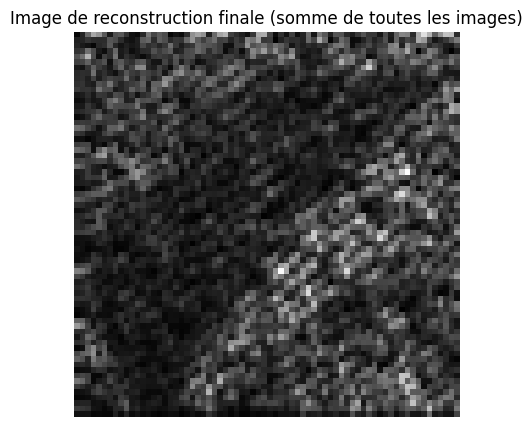

In [ ]:
# Calculer la somme de toutes les images reconstruites
final_reconstruction = sum(list_reconstruction)

# Afficher l'image de reconstruction finale
plt.figure(figsize=(10, 5))
plt.imshow(final_reconstruction, cmap='gray')
plt.title("Image de reconstruction finale (somme de toutes les images)")
plt.axis('off')
plt.show()

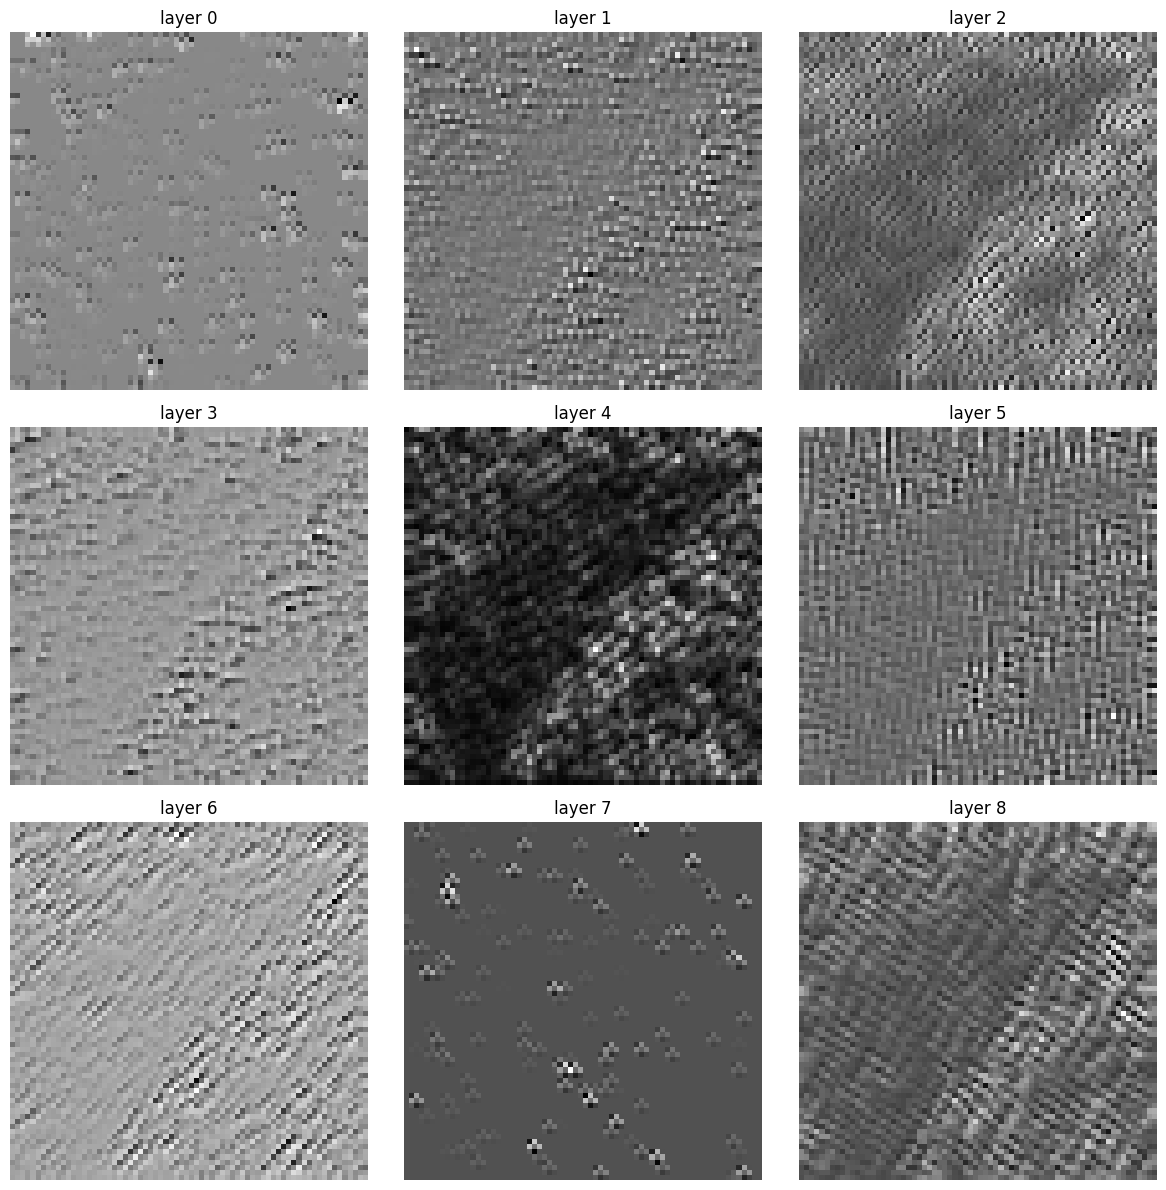

In [ ]:
plt.figure(figsize=(12, 12))
for i, img in enumerate(list_reconstruction):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'layer {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Les 8 layers à la suite, affichage après chaque layer et l'image finale

Reconstruction du layer n°0...
Convergence atteinte !
Reconstruction du layer n°1...
Convergence atteinte !
Reconstruction du layer n°2...
Convergence atteinte !
Reconstruction du layer n°3...
Convergence atteinte !
Reconstruction du layer n°4...
Reconstruction du layer n°5...
Convergence atteinte !
Reconstruction du layer n°6...
Convergence atteinte !
Reconstruction du layer n°7...
Convergence atteinte !
Reconstruction du layer n°8...
Convergence atteinte !


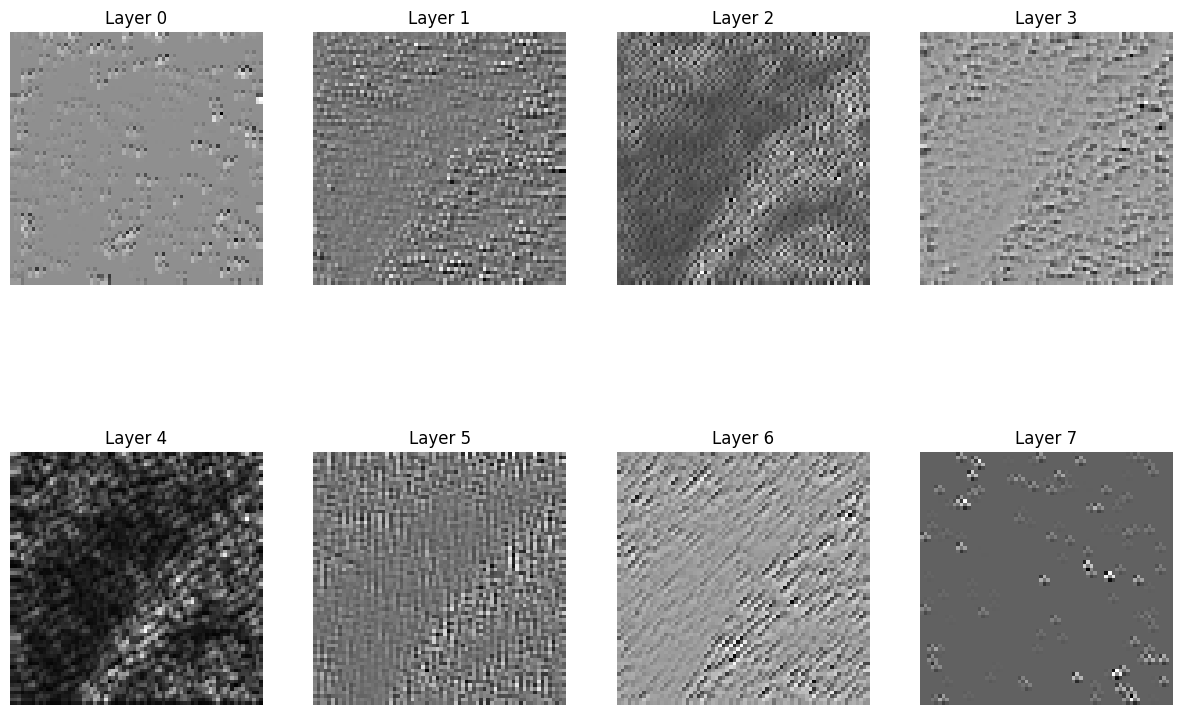

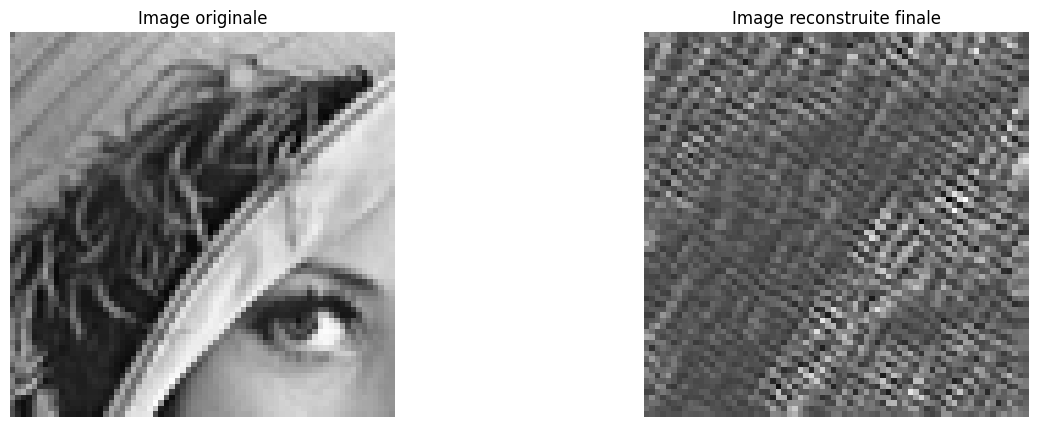

PSNR entre l'image originale et l'image reconstruite : 6.24 dB


In [ ]:
import scipy.signal
import numpy as np
import cv2
import matplotlib.pyplot as plt

def soft_threshold(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def convolve2d(x, kernel):
    """ Convolution 2D avec padding symétrique """
    return scipy.signal.convolve2d(x, kernel, mode='same', boundary='symm')

def initialize_missing_pixels(image, selected_pixels):
    """
    Initialisation des pixels manquants par la moyenne des pixels observés.
    """
    H, W = image.shape
    b_original = image.flatten()
    x_init = np.zeros_like(b_original)
    
    for i in range(H * W):
        if i in selected_pixels:
            x_init[i] = b_original[i]
        else:
            x_init[i] = np.mean(b_original[selected_pixels])
    
    return x_init

def fista_with_missing_pixel_update(A, A_T, b, lambda_, conv1_f, conv1_b, conv2_f, conv2_b,
                                    soft_thr_fista, max_iter=100, tol=1e-15, x_init=None):
    """
    FISTA avec mise à jour des pixels manquants.
    """
    x = x_init if x_init is not None else np.zeros(A.shape[1])
    y = x.copy()
    t = 1
    L = np.linalg.norm(A, ord=2) ** 2  
    
    H, W = int(np.sqrt(A.shape[1])), int(np.sqrt(A.shape[1]))
    
    for _ in range(max_iter):
        x_old = x.copy()
        gradient = A_T @ (A @ y - b)
        x = soft_threshold(y - gradient * lambda_ / L, lambda_ / L)
        
        x = x.reshape(H, W)
        x_conv1 = convolve2d(x, conv1_f[0, 0])
        x_relu1 = np.maximum(x_conv1, 0)
        x_conv2 = convolve2d(x_relu1, conv2_f[0, 0])
        x_thresh = soft_threshold(x_conv2, soft_thr_fista)
        x_conv3 = convolve2d(x_thresh, conv1_b[0, 0])
        x_relu2 = np.maximum(x_conv3, 0)
        x_conv4 = convolve2d(x_relu2, conv2_b[0, 0])
        x = x_conv4  
        x = x.flatten()
        
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = x + ((t - 1) / t_new) * (x - x_old)
        t = t_new
        
        if np.linalg.norm(x - x_old) < tol:
            print("Convergence atteinte !")
            break
    
    return x

image = cv2.imread("data/Set11/lena256.tif", cv2.IMREAD_GRAYSCALE)
image = image[80:150, 80:150]  
H, W = image.shape
b_original = image.flatten()

CS_RATIO = 0.40
M = int(CS_RATIO * H * W)
selected_pixels = np.random.choice(H * W, M, replace=False)

Phi = np.zeros((M, H * W))
for i, pixel in enumerate(selected_pixels):
    Phi[i, pixel] = 1
PhiT = Phi.T

b = Phi @ b_original

x_current = initialize_missing_pixels(image, selected_pixels)  

plt.figure(figsize=(15, 10))
for i in range(9):
    print(f"Reconstruction du layer n°{i}...")
    lambda_fista = model.state_dict()[f'module.fcs.{i}.lambda_step'].item()
    soft_thr_fista = model.state_dict()[f'module.fcs.{i}.soft_thr'].item()
    conv1_f = model.state_dict()[f'module.fcs.{i}.conv1_forward'].detach().cpu().numpy()
    conv2_f = model.state_dict()[f'module.fcs.{i}.conv2_forward'].detach().cpu().numpy()
    conv1_b = model.state_dict()[f'module.fcs.{i}.conv1_backward'].detach().cpu().numpy()
    conv2_b = model.state_dict()[f'module.fcs.{i}.conv2_backward'].detach().cpu().numpy()
    
    x_current = fista_with_missing_pixel_update(Phi, PhiT, b, lambda_fista, conv1_f, conv1_b, conv2_f, conv2_b,
                                                soft_thr_fista, max_iter=10000, tol=1e-15, x_init=x_current)
    
    image_reconstructed = x_current.reshape(H, W)

    if i<8:
        plt.subplot(2, 4, i+1)
        plt.title(f"Layer {i}")
        plt.imshow(image_reconstructed, cmap='gray')
        plt.axis('off')

plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Image reconstruite finale")
plt.imshow(image_reconstructed, cmap='gray')
plt.axis('off')
plt.show()


psnr_value = compute_psnr(image, image_reconstructed)
print(f"PSNR entre l'image originale et l'image reconstruite : {psnr_value:.2f} dB")


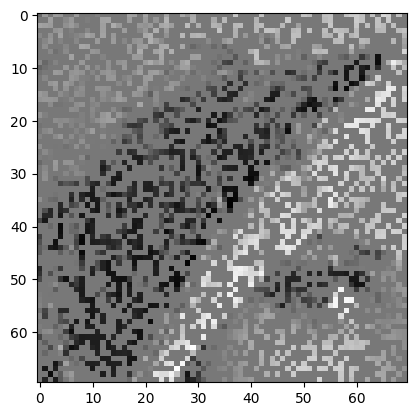

In [ ]:
def initialize_missing_pixels(image, selected_pixels):
    """
    Initialisation des pixels manquants par la moyenne des pixels observés.
    """
    H, W = image.shape
    b_original = image.flatten()
    x_init = np.zeros_like(b_original)
    
    for i in range(H * W):
        if i in selected_pixels:
            x_init[i] = b_original[i]
        else:
            x_init[i] = np.mean(b_original[selected_pixels])
    
    return x_init

image = cv2.imread("data/Set11/lena256.tif", cv2.IMREAD_GRAYSCALE)
image = image[80:150, 80:150]  
H, W = image.shape
b_original = image.flatten()

CS_RATIO = 0.40
M = int(CS_RATIO * H * W)
selected_pixels = np.random.choice(H * W, M, replace=False)

Phi = np.zeros((M, H * W))
for i, pixel in enumerate(selected_pixels):
    Phi[i, pixel] = 1
PhiT = Phi.T

b = Phi @ b_original

x_current = initialize_missing_pixels(image, selected_pixels)  

plt.imshow(x_current.reshape(70,70), cmap='gray')


## Test de l'hypothèse : $F^* \circ F = I$ ?

In [ ]:
lambda_fista = model.state_dict()['module.fcs.8.lambda_step'].item()
soft_thr_fista = model.state_dict()['module.fcs.8.soft_thr'].item()

conv1_f = model.state_dict()['module.fcs.8.conv1_forward'].detach().cpu().numpy()
conv2_f = model.state_dict()['module.fcs.8.conv2_forward'].detach().cpu().numpy()
conv1_b = model.state_dict()['module.fcs.8.conv1_backward'].detach().cpu().numpy()
conv2_b = model.state_dict()['module.fcs.8.conv2_backward'].detach().cpu().numpy()

In [ ]:
import numpy as np
from scipy.signal import convolve2d

# Matrice d'entrée remplie de 1
x = np.ones((7, 7))

# Transformation F
x_conv1 = convolve2d(x, conv1_f[0, 0], mode='same')
x_relu1 = np.maximum(x_conv1, 0)
x_conv2 = convolve2d(x_relu1, conv2_f[0, 0], mode='same')

# Transformation inverse F tilde
x_conv3 = convolve2d(x_conv2, conv1_b[0, 0], mode='same')
x_relu2 = np.maximum(x_conv3, 0)
x_conv4 = convolve2d(x_relu2, conv2_b[0, 0], mode='same')

# Résultat final
x_reconstructed = x_conv4

print("Matrice originale :\n", x)
print("Matrice reconstruite :\n", x_reconstructed)
print('---------------')
print((x/x_reconstructed).flatten())


Matrice originale :
 [[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]
Matrice reconstruite :
 [[ 8.78290091e-06 -3.26491171e-04 -3.95444120e-04 -4.29853783e-05
   3.45547175e-04  3.09336047e-04  3.16887412e-04]
 [-1.60028153e-04  9.60974380e-05  5.38062032e-04  7.35249825e-04
   3.44816751e-04  4.04978722e-04  8.22786291e-04]
 [ 3.10389598e-04  1.02472413e-03  1.77147450e-03  2.17575107e-03
   1.90741455e-03  1.27835800e-03  4.34195097e-04]
 [ 1.54107825e-04  1.22513650e-03  2.11812345e-03  2.35239290e-03
   2.46118326e-03  2.49690081e-03  8.49963136e-04]
 [ 0.00000000e+00  9.06598287e-04  1.91648927e-03  2.33065713e-03
   2.38957344e-03  2.20085017e-03  7.71264098e-04]
 [-4.31322895e-04  8.50712080e-04  2.01112270e-03  2.05113306e-03
   2.20411713e-03  2.83819742e-03  1.12439172e-03]
 [ 8.41626698e-04  2.21642486e-03  2.69620451e-03  2.15232455e-03
   2.35900582e-03 

C:\Users\boque\AppData\Local\Temp\ipykernel_7936\3831127368.py:23: RuntimeWarning: divide by zero encountered in divide
  print((x/x_reconstructed).flatten())


On n'a pas $F^*\circ F = I$ donc les valeurs apprises ne sont plus utilisables dans un FISTA

## Test avec la transformée en Wavelet

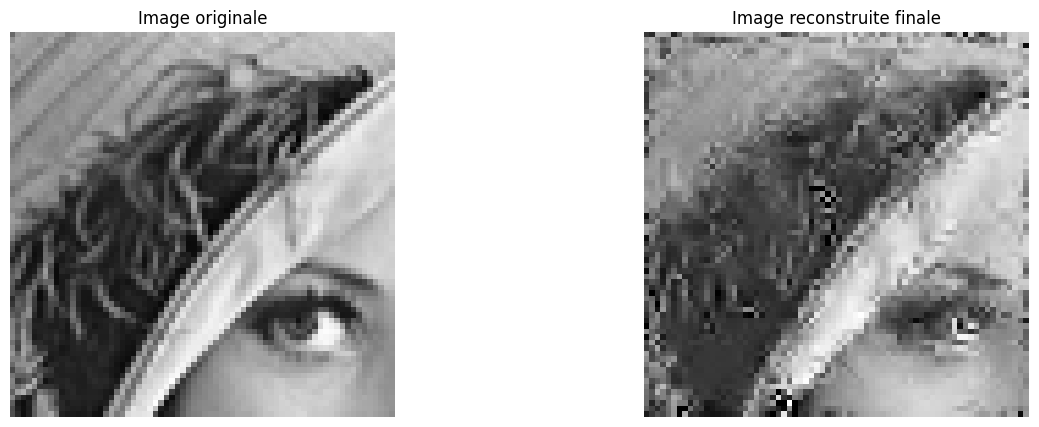

PSNR entre l'image originale et l'image reconstruite : 31.29 dB


In [3]:
import scipy.signal
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pywt

def wavelet_transform_db3(image):
    coeffs = pywt.wavedec2(image, 'db3', mode='zero')
    coeff_array, coeff_slices = pywt.coeffs_to_array(coeffs)
    return coeff_array.flatten(), coeff_slices, coeff_array.shape

def inverse_wavelet_transform_db3(coeff_array, coeff_slices, shape):
    coeffs = pywt.array_to_coeffs(coeff_array.reshape(shape), coeff_slices, output_format='wavedec2')
    return pywt.waverec2(coeffs, 'db3', mode='zero')[:shape[0], :shape[1]]

def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("L'image n'a pas été chargée. Vérifie le chemin du fichier.")
    return image[80:150, 80:150]

def fista_wavelet(Phi, PhiT, b, lambda_1, lambda_2, max_iter=100, tol=1e-15):
    x = np.zeros(Phi.shape[1])
    y = x.copy()
    t = 1
    L = np.linalg.norm(Phi, ord=2) ** 2
    
    for _ in range(max_iter):
        x_old = x.copy()
        # print(f'Phi.shape:{Phi.shape}, PhiT.shape:{PhiT.shape}, b.shape:{b.shape}, y.shape:{y.shape}')
        gradient = PhiT @ (Phi @ y - b)
        z = y - gradient * lambda_1 / L
        # print(f'z.shape:{z.shape}')
        # Apply wavelet transform
        D_x, coeff_slices, coeff_shape = wavelet_transform_db3(z.reshape(H, W))
        
        # Soft thresholding in the wavelet domain
        D_x = np.sign(D_x) * np.maximum(np.abs(D_x) - lambda_2 / L, 0)
        
        # Inverse wavelet transform
        x = inverse_wavelet_transform_db3(D_x, coeff_slices, coeff_shape).flatten()

        # print(f'coeff_shape:{coeff_shape}')
        # print(f'x_reconstructed.shape:{x.shape}')
        
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = x + ((t - 1) / t_new) * (x - x_old)
        t = t_new
        
        if np.linalg.norm(x - x_old) < tol:
            print("Convergence atteinte !")
            break
    
    return x

image = load_image("data/Set11/lena256.tif")
H, W = 70, 70
# b_original, _, _ = wavelet_transform_coif5(image)
b_original = image.flatten()

CS_RATIO = 0.40
M = int(CS_RATIO * len(b_original))
selected_pixels = np.random.choice(len(b_original), M, replace=False)

Phi = np.zeros((M, len(b_original)))
for i, pixel in enumerate(selected_pixels):
    Phi[i, pixel] = 1
PhiT = Phi.T

b = Phi @ b_original

lambda_fista = 1e-2
x_reconstructed = fista_wavelet(Phi, PhiT, b, lambda_1 = lambda_fista, lambda_2 = 1e-2, max_iter=30000, tol=1e-15)

image_reconstructed = x_reconstructed.reshape(H, W)
image_reconstructed = np.clip(image_reconstructed, 0, 255)  # Clipper dans la plage valide
image_reconstructed = image_reconstructed.astype(np.uint8)  # Convertir en uint8

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Image reconstruite finale")
plt.imshow(image_reconstructed, cmap='gray')
plt.axis('off')
plt.show()

psnr_value = compute_psnr(image, image_reconstructed)
print(f"PSNR entre l'image originale et l'image reconstruite : {psnr_value:.2f} dB")
